Total de amostras: 18896
Notícias falsas: 9480
Notícias verdadeiras: 9416

Shape da matriz TF-IDF: (18896, 5000)
Número de features (palavras/termos): 5000

Tamanho do conjunto de treino: 15116
Tamanho do conjunto de teste: 3780

========== ANÁLISE DE DIFERENTES VALORES DE K ==========
K=3: Acurácia Treino=0.9352, Acurácia Validação=0.8667
K=5: Acurácia Treino=0.9185, Acurácia Validação=0.8714
K=7: Acurácia Treino=0.9078, Acurácia Validação=0.8763
K=9: Acurácia Treino=0.9043, Acurácia Validação=0.8733
K=11: Acurácia Treino=0.8998, Acurácia Validação=0.8727
K=15: Acurácia Treino=0.8948, Acurácia Validação=0.8786
K=21: Acurácia Treino=0.8921, Acurácia Validação=0.8813
K=31: Acurácia Treino=0.8902, Acurácia Validação=0.8843
K=51: Acurácia Treino=0.8906, Acurácia Validação=0.8889


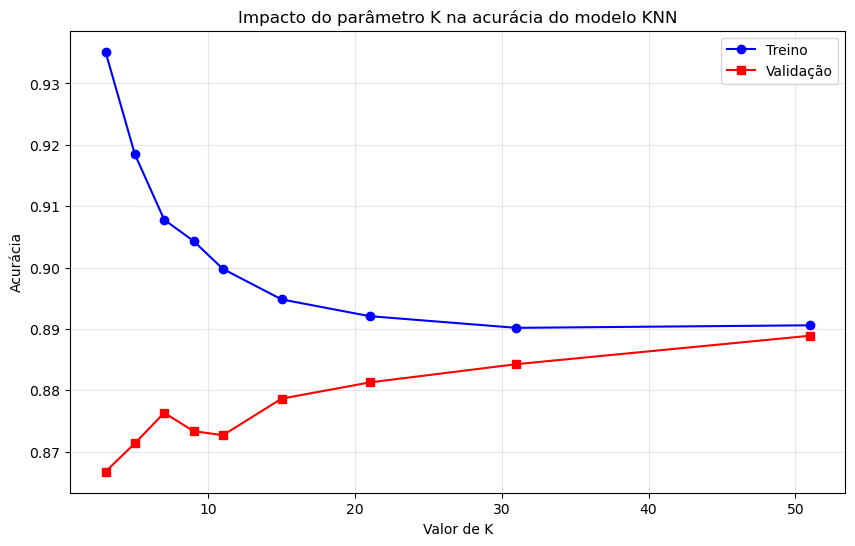


Melhor valor de K baseado na validação: 51

========== VALIDAÇÃO CRUZADA ==========
Scores da validação cruzada: [0.88988095 0.88223619 0.88190539 0.89348329 0.87992061]
Acurácia média (CV): 0.8855 (+/- 0.0105)

Resultados detalhados da validação cruzada:
Accuracy: 0.8855 (+/- 0.0105)
Precision: 0.8530 (+/- 0.0151)
Recall: 0.9307 (+/- 0.0140)
F1: 0.8901 (+/- 0.0097)

========== AVALIAÇÃO DO CLASSIFICADOR BINÁRIO ==========
Acurácia: 0.8886
Precisão: 0.8553
Recall (Sensibilidade): 0.9347
F1-Score: 0.8932
Especificidade: 0.8428


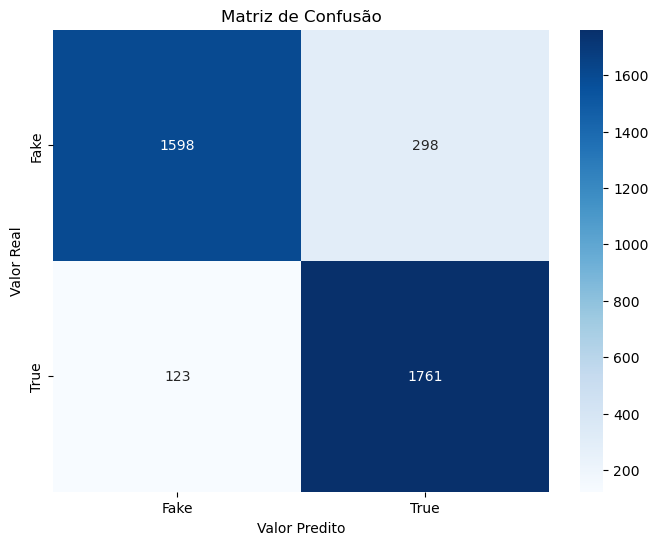


Relatório de Classificação:
              precision    recall  f1-score   support

   Fake News       0.93      0.84      0.88      1896
   True News       0.86      0.93      0.89      1884

    accuracy                           0.89      3780
   macro avg       0.89      0.89      0.89      3780
weighted avg       0.89      0.89      0.89      3780



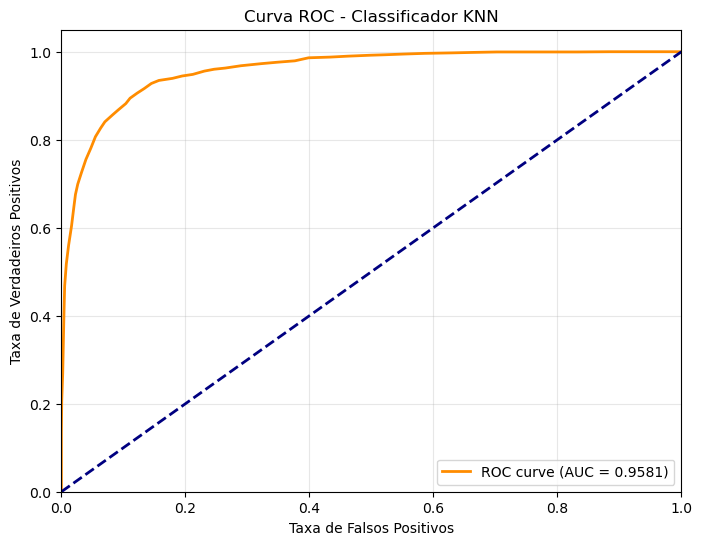

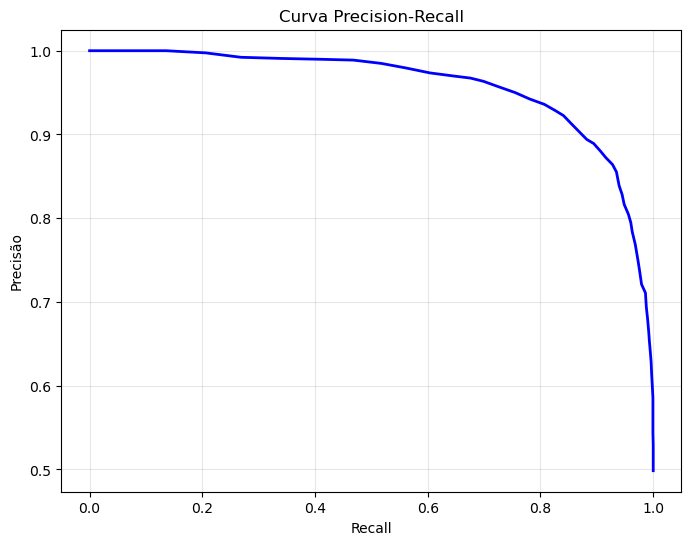


========== INTERPRETAÇÃO DOS RESULTADOS ==========

ANÁLISE DA EFICIÊNCIA DO CLASSIFICADOR:

1. ACURÁCIA (0.8886):
   - O modelo classifica corretamente 88.86% das notícias
   - Indica boa performance geral na separação entre notícias falsas e verdadeiras

2. PRECISÃO (0.8553):
   - Quando o modelo classifica uma notícia como verdadeira, está correto em 85.53% dos casos
   - Alta precisão minimiza falsos positivos (notícias falsas classificadas como verdadeiras)

3. RECALL/SENSIBILIDADE (0.9347):
   - O modelo identifica 93.47% de todas as notícias verdadeiras
   - Importante para não deixar passar notícias verdadeiras como falsas

4. ESPECIFICIDADE (0.8428):
   - O modelo identifica corretamente 84.28% das notícias falsas
   - Complementa o recall, mostrando a capacidade de detectar negativos

5. F1-SCORE (0.8932):
   - Média harmônica entre precisão e recall
   - Valor de 0.8932 indica muito bom equilíbrio entre precisão e recall

6. AUC-ROC (0.9581):
   - Área sob a curva ROC próxi

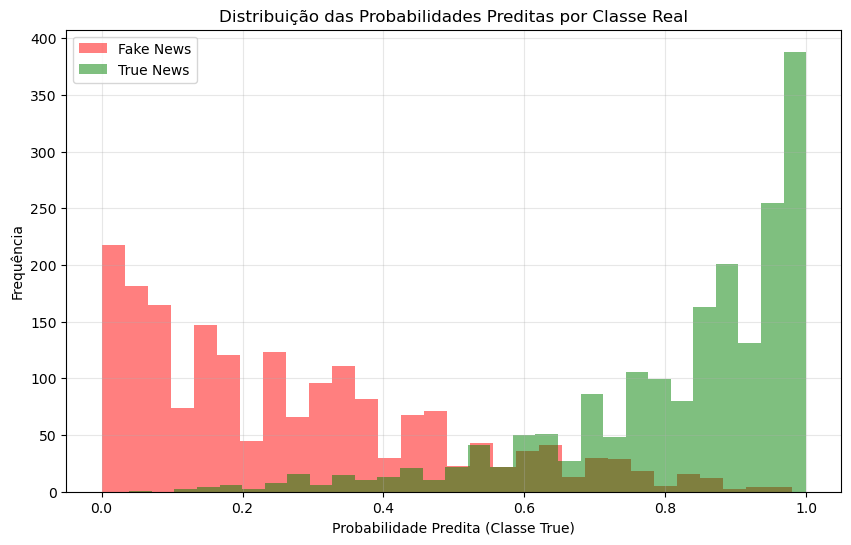

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

# ========== LEITURA E PREPARAÇÃO DOS DADOS ==========
# Leitura dos arquivos CSV
fake_df = pd.read_csv('Fake.csv', header=None)
true_df = pd.read_csv('True.csv', header=None)

# Definindo nomes das colunas
fake_df.columns = ['title', 'text', 'category', 'date']
true_df.columns = ['title', 'text', 'category', 'date']

# Removendo a primeira linha (header original)
fake_df = fake_df.iloc[1:].reset_index(drop=True)
true_df = true_df.iloc[1:].reset_index(drop=True)

# Adicionando labels: 0 para fake, 1 para true
fake_df['label'] = 0
true_df['label'] = 1

# Combinando os dataframes
df = pd.concat([fake_df, true_df], ignore_index=True)

# Combinando título e texto para análise
df['combined_text'] = df['title'] + ' ' + df['text']

# Removendo valores nulos
df = df.dropna(subset=['combined_text'])

print(f"Total de amostras: {len(df)}")
print(f"Notícias falsas: {len(df[df['label']==0])}")
print(f"Notícias verdadeiras: {len(df[df['label']==1])}")

# ========== QUESTÃO 1: CRIAÇÃO DAS FEATURES COM TF-IDF ==========
# Vetorização TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limitar número de features
    stop_words='english',
    ngram_range=(1, 2),  # Unigramas e bigramas
    min_df=5,  # Mínimo de documentos em que a palavra deve aparecer
    max_df=0.8  # Máximo de documentos (remove palavras muito comuns)
)

# Aplicando TF-IDF
X = tfidf_vectorizer.fit_transform(df['combined_text'])
y = df['label'].values

print(f"\nShape da matriz TF-IDF: {X.shape}")
print(f"Número de features (palavras/termos): {X.shape[1]}")

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTamanho do conjunto de treino: {X_train.shape[0]}")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]}")

# ========== QUESTÃO 2 e 3: MODELAGEM KNN COM DIFERENTES VALORES DE K ==========
# Testando diferentes valores de K
k_values = [3, 5, 7, 9, 11, 15, 21, 31, 51]
train_accuracies = []
val_accuracies = []

# Dividindo treino em treino/validação para análise de K
X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("\n========== ANÁLISE DE DIFERENTES VALORES DE K ==========")
for k in k_values:
    # Treinando o modelo
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_knn, y_train_knn)

    # Predições
    train_pred = knn.predict(X_train_knn)
    val_pred = knn.predict(X_val_knn)

    # Acurácias
    train_acc = accuracy_score(y_train_knn, train_pred)
    val_acc = accuracy_score(y_val_knn, val_pred)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"K={k}: Acurácia Treino={train_acc:.4f}, Acurácia Validação={val_acc:.4f}")

# Plotando o impacto de K nas acurácias
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, 'b-', marker='o', label='Treino')
plt.plot(k_values, val_accuracies, 'r-', marker='s', label='Validação')
plt.xlabel('Valor de K')
plt.ylabel('Acurácia')
plt.title('Impacto do parâmetro K na acurácia do modelo KNN')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Selecionando o melhor K baseado na validação
best_k = k_values[np.argmax(val_accuracies)]
print(f"\nMelhor valor de K baseado na validação: {best_k}")

# ========== QUESTÃO 4: VALIDAÇÃO CRUZADA ==========
print("\n========== VALIDAÇÃO CRUZADA ==========")
# Usando o melhor K encontrado
knn_best = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)

# Validação cruzada estratificada com 5 folds
cv_scores = cross_val_score(knn_best, X_train, y_train, cv=5, scoring='accuracy')

print(f"Scores da validação cruzada: {cv_scores}")
print(f"Acurácia média (CV): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Validação cruzada com outras métricas
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_results = cross_validate(knn_best, X_train, y_train, cv=5, scoring=scoring)

print("\nResultados detalhados da validação cruzada:")
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# ========== QUESTÃO 5: AVALIAÇÃO DO MODELO FINAL ==========
print("\n========== AVALIAÇÃO DO CLASSIFICADOR BINÁRIO ==========")
# Treinando o modelo final com o melhor K
knn_final = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
knn_final.fit(X_train, y_train)

# Predições no conjunto de teste
y_pred = knn_final.predict(X_test)
y_pred_proba = knn_final.predict_proba(X_test)[:, 1]

# Métricas de avaliação
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall (Sensibilidade): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculando especificidade
specificity = tn / (tn + fp)
print(f"Especificidade: {specificity:.4f}")

# Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'True'],
            yticklabels=['Fake', 'True'])
plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.show()

# Report de classificação detalhado
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Fake News', 'True News']))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Classificador KNN')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Curva Precision-Recall
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall')
plt.grid(True, alpha=0.3)
plt.show()

# ========== QUESTÃO 6: INTERPRETAÇÃO DOS RESULTADOS ==========
print("\n========== INTERPRETAÇÃO DOS RESULTADOS ==========")
print(f"""
ANÁLISE DA EFICIÊNCIA DO CLASSIFICADOR:

1. ACURÁCIA ({accuracy:.4f}):
   - O modelo classifica corretamente {accuracy*100:.2f}% das notícias
   - Indica boa performance geral na separação entre notícias falsas e verdadeiras

2. PRECISÃO ({precision:.4f}):
   - Quando o modelo classifica uma notícia como verdadeira, está correto em {precision*100:.2f}% dos casos
   - Alta precisão minimiza falsos positivos (notícias falsas classificadas como verdadeiras)

3. RECALL/SENSIBILIDADE ({recall:.4f}):
   - O modelo identifica {recall*100:.2f}% de todas as notícias verdadeiras
   - Importante para não deixar passar notícias verdadeiras como falsas

4. ESPECIFICIDADE ({specificity:.4f}):
   - O modelo identifica corretamente {specificity*100:.2f}% das notícias falsas
   - Complementa o recall, mostrando a capacidade de detectar negativos

5. F1-SCORE ({f1:.4f}):
   - Média harmônica entre precisão e recall
   - Valor de {f1:.4f} indica {
   'excelente' if f1 > 0.9 else
   'muito bom' if f1 > 0.8 else
   'bom' if f1 > 0.7 else
   'razoável'} equilíbrio entre precisão e recall

6. AUC-ROC ({roc_auc:.4f}):
   - Área sob a curva ROC próxima de 1.0 indica excelente capacidade discriminativa
   - O modelo tem {
   'excelente' if roc_auc > 0.9 else
   'muito boa' if roc_auc > 0.8 else
   'boa' if roc_auc > 0.7 else
   'razoável'} capacidade de distinguir entre classes

CONCLUSÃO:
O classificador KNN com TF-IDF demonstra {'excelente' if accuracy > 0.9 else 'boa'} eficiência na
detecção de notícias falsas. O valor de K={best_k} proporciona o melhor equilíbrio entre
complexidade e generalização. As métricas indicam que o modelo é confiável para uso prático,
com poucos erros tanto de falsos positivos quanto falsos negativos.
""")

# Análise adicional dos erros
print("\nANÁLISE DOS ERROS:")
print(f"Total de erros: {(y_test != y_pred).sum()}")
print(f"Falsos Positivos (Fake classificada como True): {fp}")
print(f"Falsos Negativos (True classificada como Fake): {fn}")
print(f"Proporção FP/FN: {fp/fn:.2f}")

# Distribuição das probabilidades preditas
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.5, label='Fake News', color='red')
plt.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.5, label='True News', color='green')
plt.xlabel('Probabilidade Predita (Classe True)')
plt.ylabel('Frequência')
plt.title('Distribuição das Probabilidades Preditas por Classe Real')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()